**Nidhi Rajkumar Saini <br>
USCID: 3730422872**

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import operator
import math
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import OLSInfluence as influence
from tabulate import tabulate
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import neighbors
from sklearn.preprocessing import MinMaxScaler

In [2]:
def regression(predictor):
    model = ols("PE ~"+ predictor, data=df).fit()
    predictions = model.predict(df[predictor]) 
    linearCoeffs.append(model.params)
    pvals.append(model.pvalues)
    print("Summary for",predictor,"is as follows:\n",model.summary(),"\n")
    #  Compute the influence to get Cook's distance
    inf = influence(model)
    # cooks_distance is an attribute of influence
    C, P = inf.cooks_distance
    return model.rsquared,C,predictions

In [3]:
def plotRegression(X,xlabel,r2,response):
    plt.style.use('default')
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(X, response, color='m', label='Regression model')
    ax.scatter(X, y, edgecolor='c', facecolor='white', alpha=0.7, label='Sample data')
    ax.set_ylabel('PE', fontsize=14)
    ax.set_xlabel(xlabel, fontsize=14)
    ax.text(0.8, 0.1, 'Simple Linear Regression', fontsize=13, ha='center', va='center', transform=ax.transAxes, color='grey', alpha=0.5)
    ax.legend(facecolor='white', fontsize=11)
    ax.set_title('$R^2= %.2f$' % r2, fontsize=18)
    fig.tight_layout()
    plt.show()

In [4]:
def plotOutliers(cookdist, xlabel):
    idx = []
    _, ax1 = plt.subplots(figsize=(9,6))
    threshold = 4/len(cookdist)
    # stem plot - the x-axis represents the index of the observation and the y-axis its Cook's distance
    ax1.stem(cookdist, basefmt=" ")
    # horizontal line showing the threshold value
    ax1.axhline(4/len(cookdist), c='r', ls='--', lw=1, label="$\frac{4}{n}$")
    # the observations with Cook's distances higher than the threshold value are labeled in the plot
    influencial_data = cookdist[cookdist > threshold]
    for index, value in influencial_data.items():
        idx.append(index)
    # labels and title
    ax1.set_xlabel('Index', fontsize=14)
    ax1.set_ylabel('Cook\'s distance', fontsize=14)
    ax1.set_title('Cook\'s distance', fontsize=20)
    plt.show()
    return idx

In [5]:
def plotTrainTestError(trainErrorDict, testErrorDict):
    # plot K vs training error 
    plt.plot(trainErrorDict.keys(), trainErrorDict.values(), 'green', label = 'Train Error')
    # plot K vs testing error
    plt.plot(testErrorDict.keys(), testErrorDict.values(), 'magenta', label = 'Test Error')
    plt.title('MSE vs 1/k using KNN Regression', style = 'oblique')
    plt.ylabel('MSE')
    plt.xlabel('1/k')
    plt.legend()
    plt.show()

In [6]:
MSEvals = pd.DataFrame(columns=['trainMSE', 'testMSE'])

# Combined Cycle Power Plant Dataset

## Loading the Combined Cycle Power Plant data

In [7]:
df = pd.read_excel('../data/CCPP/Folds5x2_pp.xlsx')
df

,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90
...,...,...,...,...,...
9563,16.65,49.69,1014.01,91.00,460.03
9564,13.19,39.18,1023.67,66.78,469.62
9565,31.32,74.33,1012.92,36.48,429.57
9566,24.48,69.45,1013.86,62.39,435.74


## Exploring the data

### How many rows are in this data set? How many columns? What do the rows and columns represent?

In [8]:
df.info()
print("(Rows, Columns):",df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9568 entries, 0 to 9567
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AT      9568 non-null   float64
 1   V       9568 non-null   float64
 2   AP      9568 non-null   float64
 3   RH      9568 non-null   float64
 4   PE      9568 non-null   float64
dtypes: float64(5)
memory usage: 373.9 KB
(Rows, Columns): (9568, 5)


We can observe that this dataset consists of 5 numerical variables or columns (float64) and 9568 rows. There are no missing values (9568 non-null) across all the variables and the data type (dtypes) is a float point number.<br>

The columns: 'AT', 'V', 'AP', 'RH' represent 4 features which are hourly average ambient variables Temperature (AT), Exhaust Vacuum (V), Ambient Pressure (AP) and Relative Humidity (RH) to predict the net hourly electrical energy output (PE) of the plant.<br>

The rows represent 9568 data points collected from a Combined Cycle Power Plant over 6 years (2006-2011), when the plant was set to work with full load.

### Pairwise scatterplots of all the variables in the data set including the predictors (independent variables) with the dependent variable

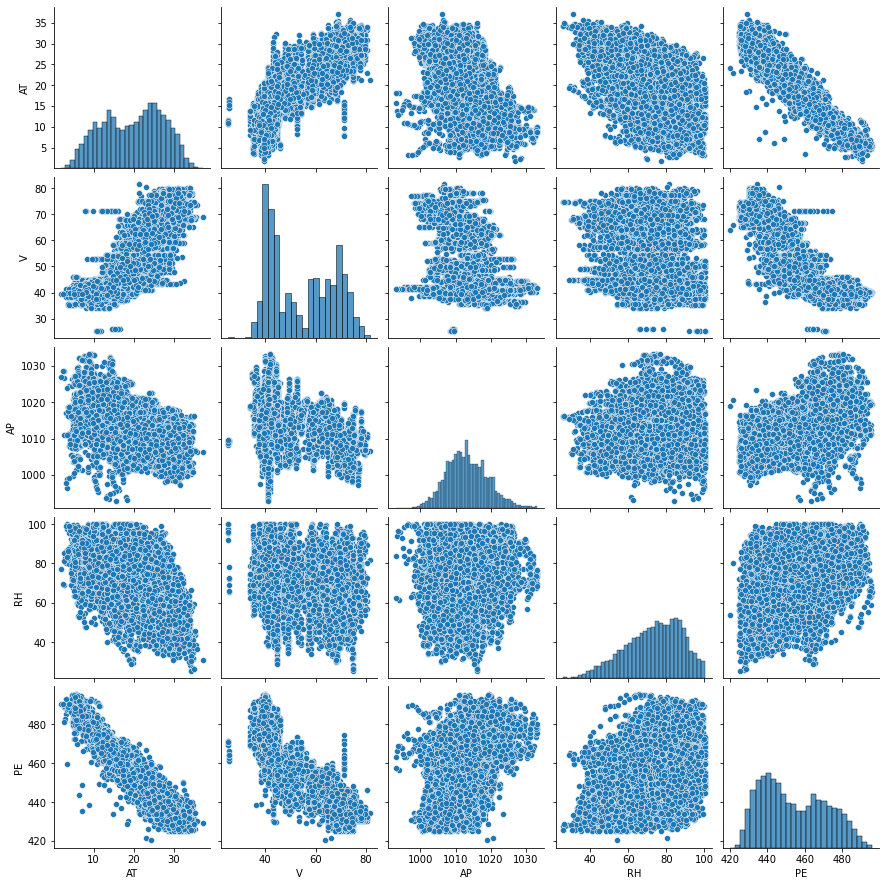

In [9]:
sns.pairplot(df, kind='scatter')

From the above pairwise scatterplot of all the variables in the data set, we can observe that AT and V have a strong negative correlation with the target variable (PE). AP and RH have a weak positive correlation with PE. We also notice the problem of multicollinearity here, that is features AT and V are highly correlated with each other. As features of a dataset should be independent of each other, we can solve this problem by selecting the feature (AT) that more strongly correlates with the target variable (PE).

### What are the mean, the median, range, first and third quartiles, and interquartile ranges of each of the variables in the dataset?

In [10]:
print("The mean, median, range, first and third quartiles, and interquartile ranges of each of the variables in the dataset are as follows:")
table = df.describe()
table.loc['range'] = round(table.loc['max'] - table.loc['min'],3)
table.loc['IQR'] = round(table.loc['75%'] - table.loc['25%'],3)
table.rename(index={'25%': 'Q1(25%)'}, inplace=True)
table.rename(index={'50%': 'median'}, inplace=True)
table.rename(index={'75%': 'Q3(75%)'}, inplace=True)
table

The mean, median, range, first and third quartiles, and interquartile ranges of each of the variables in the dataset are as follows:


,AT,V,AP,RH,PE
count,9568.000000,9568.000000,9568.000000,9568.000000,9568.000000
mean,19.651231,54.305804,1013.259078,73.308978,454.365009
std,7.452473,12.707893,5.938784,14.600269,17.066995
min,1.810000,25.360000,992.890000,25.560000,420.260000
Q1(25%),13.510000,41.740000,1009.100000,63.327500,439.750000
median,20.345000,52.080000,1012.940000,74.975000,451.550000
Q3(75%),25.720000,66.540000,1017.260000,84.830000,468.430000
max,37.110000,81.560000,1033.300000,100.160000,495.760000
range,35.300000,56.200000,40.410000,74.600000,75.500000
IQR,12.210000,24.800000,8.160000,21.502000,28.680000


As we can observe from the above result, the dataset consists of 4 hourly average ambient variables or features and the target variable which is the Output Power (PE):<br>
Ambient Temperature (AT) in the range 1.81°C and 37.11°C,<br>
Exhaust Vacuum (V) in the range 25.36–81.56 cm Hg,<br>
Ambient Pressure (AP) in the range 992.89–1033.30 millibar,<br>
Relative Humidity (RH) in the range of 25.56% to 100.16%,<br>
Net hourly electrical energy output (PE) 420.26–495.76 MW

## Simple Linear Regression for each predictor

In [11]:
df_features = []
features = df.keys()[:-1]
for each in features:
    df_features.append(df[each])
y = df['PE']

Summary for AT is as follows:
                             OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                 8.510e+04
Date:                Sun, 13 Jun 2021   Prob (F-statistic):               0.00
Time:                        13:52:35   Log-Likelihood:                -29756.
No. Observations:                9568   AIC:                         5.952e+04
Df Residuals:                    9566   BIC:                         5.953e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    497.0341

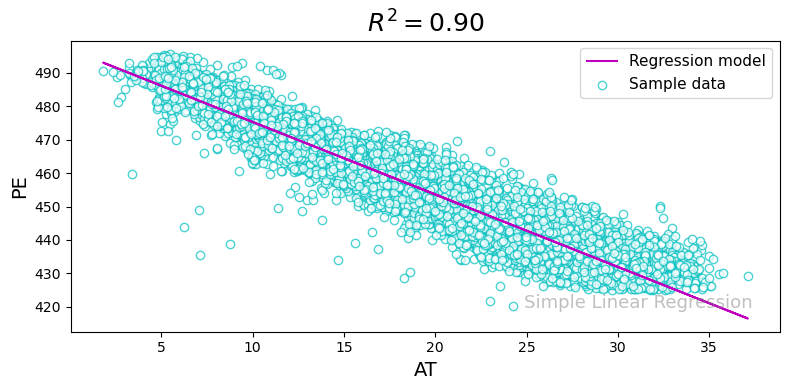

Summary for V is as follows:
                             OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.757
Model:                            OLS   Adj. R-squared:                  0.756
Method:                 Least Squares   F-statistic:                 2.972e+04
Date:                Sun, 13 Jun 2021   Prob (F-statistic):               0.00
Time:                        13:52:35   Log-Likelihood:                -33963.
No. Observations:                9568   AIC:                         6.793e+04
Df Residuals:                    9566   BIC:                         6.794e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    517.8015 

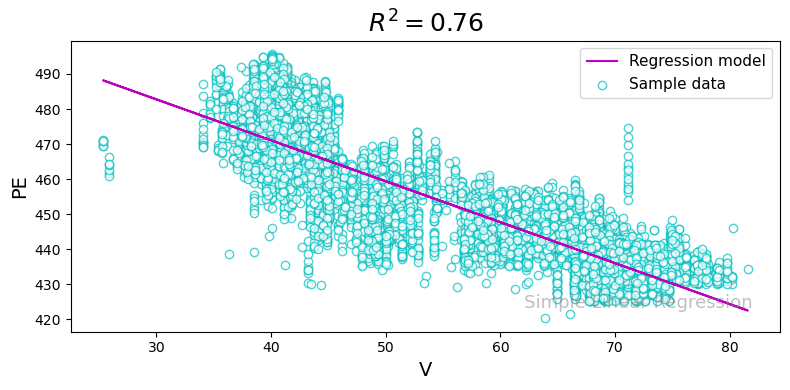

Summary for AP is as follows:
                             OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.269
Model:                            OLS   Adj. R-squared:                  0.269
Method:                 Least Squares   F-statistic:                     3516.
Date:                Sun, 13 Jun 2021   Prob (F-statistic):               0.00
Time:                        13:52:36   Log-Likelihood:                -39224.
No. Observations:                9568   AIC:                         7.845e+04
Df Residuals:                    9566   BIC:                         7.847e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1055.2610

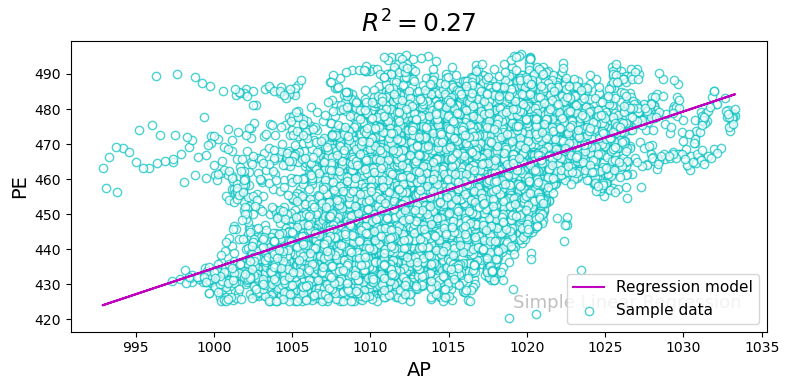

Summary for RH is as follows:
                             OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.152
Model:                            OLS   Adj. R-squared:                  0.152
Method:                 Least Squares   F-statistic:                     1714.
Date:                Sun, 13 Jun 2021   Prob (F-statistic):               0.00
Time:                        13:52:36   Log-Likelihood:                -39933.
No. Observations:                9568   AIC:                         7.987e+04
Df Residuals:                    9566   BIC:                         7.988e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    420.9618

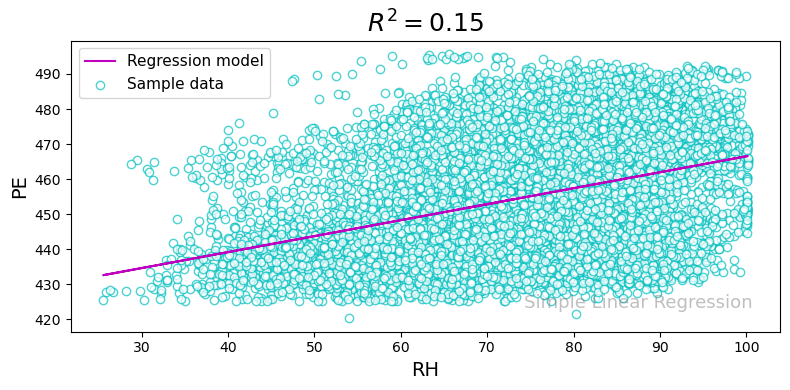

In [12]:
cooks_distance = []
pvals = []
linearCoeffs = []
for i in range(len(features)):
    r2,C,response = regression(features[i])
    plotRegression(df_features[i],features[i],r2,response)
    cooks_distance.append(C)

**In which of the models is there a statistically significant association between the predictor and the response?**

In [13]:
pvals.insert(0, 'P-values')
tableHeaders = ["AT", "V", "AP", "RH"]
tableData = []
tableData.append(pvals)
print(tabulate(tableData, tableHeaders, tablefmt="grid"))

+----------+------------------+------------------+------------------+------------------+
|          | AT               | V                | AP               | RH               |
+==========+==================+==================+==================+==================+
| P-values | Intercept    0.0 | Intercept    0.0 | Intercept    0.0 | Intercept    0.0 |
|          | AT           0.0 | V            0.0 | AP           0.0 | RH           0.0 |
|          | dtype: float64   | dtype: float64   | dtype: float64   | dtype: float64   |
+----------+------------------+------------------+------------------+------------------+


From the above table of p-values, we can observe that all the variables (AT, V, AP, RH) are statistically significant as all of them have a p-value = 0 and a p-value of less than 0.05 is considered to be statistically significant. All the models have a statistically significant association between the predictor and the response. By the above plots, it can be seen that AT has the largest significance (R-squared = 0.90) in predicting PE and V (R-squared = 0.76) is the second most significant predictor. AT and V have a strong negative correlation with the target variable (PE). AP and RH have a weak positive correlation with PE.

**Outlier Detection**

Outlier Detection for AT:



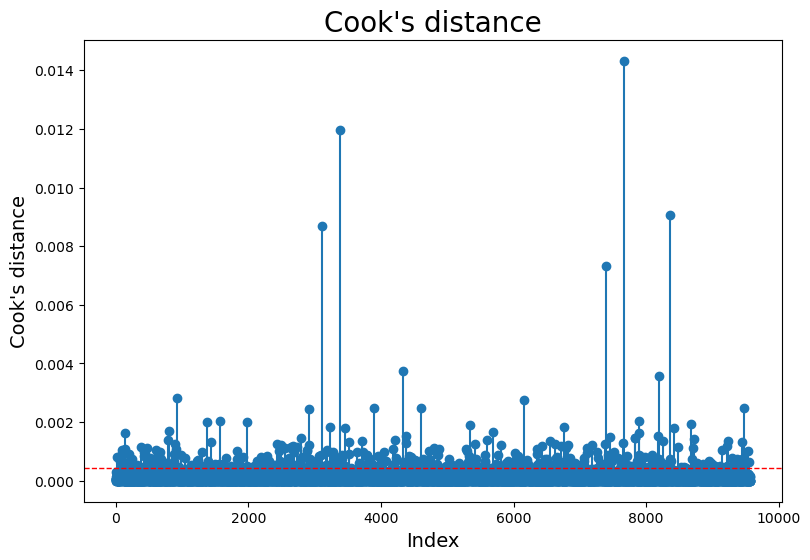

Number of outliers in predictor AT are: 416

--------------------------------------------------------------------------------------------------------------

Outlier Detection for V:



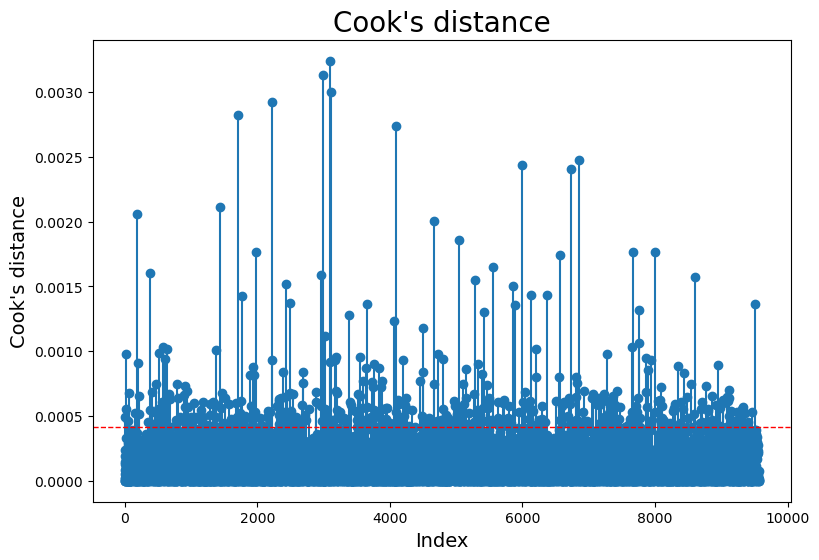

Number of outliers in predictor V are: 423

--------------------------------------------------------------------------------------------------------------

Outlier Detection for AP:



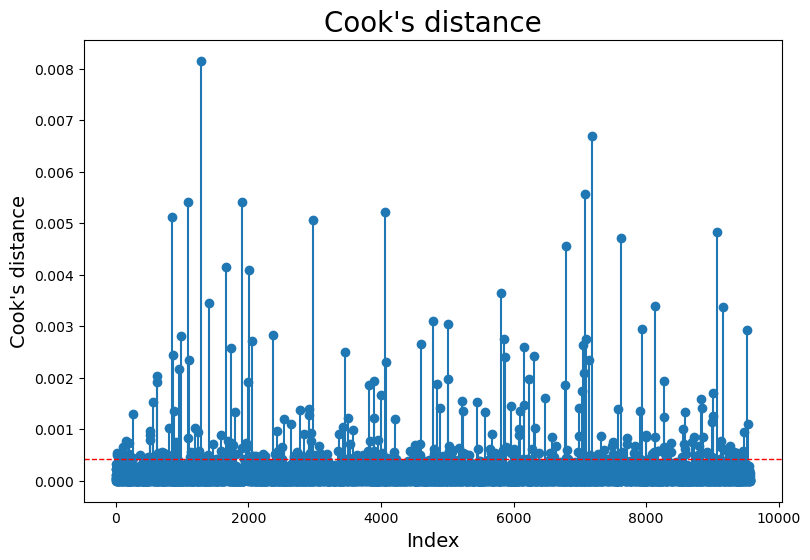

Number of outliers in predictor AP are: 300

--------------------------------------------------------------------------------------------------------------

Outlier Detection for RH:



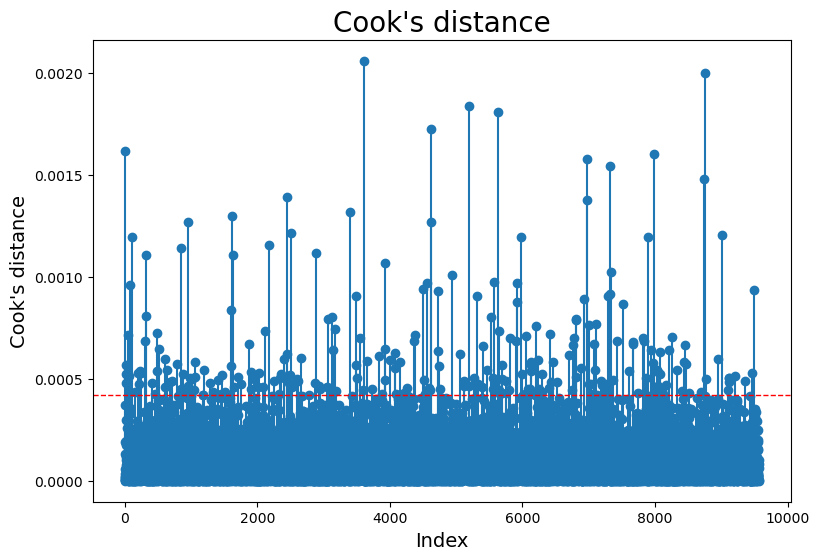

Number of outliers in predictor RH are: 249

--------------------------------------------------------------------------------------------------------------



In [14]:
for i in range(len(features)):
    print("Outlier Detection for "+features[i]+":\n")
    idx = plotOutliers(cooks_distance[i], features[i])
    print("Number of outliers in predictor "+features[i]+ " are:",len(idx))
    print("\n--------------------------------------------------------------------------------------------------------------\n")

After fitting the model, for outlier detection, we use the cooks_distance attribute available in the OLSinfluence class to obtain the Cook’s distance of each observation. The higher the Cook’s distance, the more influential the observation is. The cutoff value to indicate that the observation may be influential is calculated using 4/N, where N is the total number of observations. Hence, the above plots show the data points for each predictor and classifies them as outliers if cook's distance of those points is greater than the threshold (4/N = 4/9568 = 0.0004) ie. indicated by the red horizontal line. 

## Multiple Linear Regression 

In [15]:
# Multiple Linear Regression
model = ols("PE ~"+ '+'.join(features), data=df).fit()
multiCoeffs = model.params
multiCoeffs = multiCoeffs[1:]
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                 3.114e+04
Date:                Sun, 13 Jun 2021   Prob (F-statistic):               0.00
Time:                        13:52:38   Log-Likelihood:                -28088.
No. Observations:                9568   AIC:                         5.619e+04
Df Residuals:                    9563   BIC:                         5.622e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    454.6093      9.749     46.634      0.0

As observed above, low p-value (< 0.05) i.e. 0 indicates that we can reject the null hypothesis $H_0:β_j = 0$ for all the predictors. In other words, a predictor that has a low p-value is likely to be a meaningful addition to our model because changes in the predictor's value are related to changes in the response variable. Hence, all predictors have a statistically significant relationship with our output.

## Coefficients Plot between Simple Linear Regression and Multiple Linear Regression

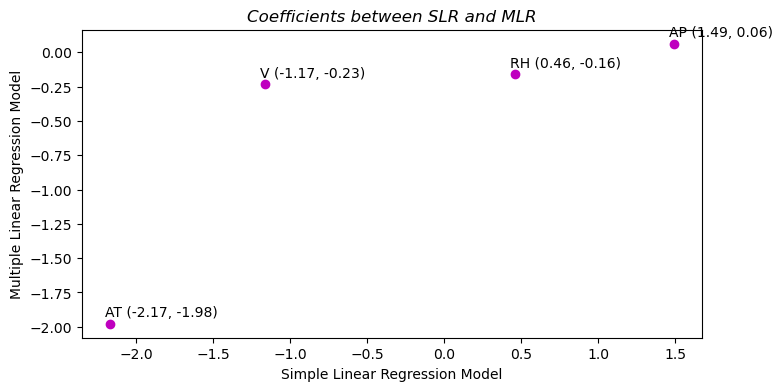

In [16]:
fig, ax = plt.subplots(figsize=(8, 4))
X = []
Y = []
for i in range(0,len(features)):
    x = linearCoeffs[i][1]
    y = multiCoeffs[i]
    X.append(x)
    Y.append(y)
    ax.text(x-0.030, y+0.050, features[i]+' ('+ str(round(x, 2)) + ', '+ str(round(y, 2)) +')', fontsize=10)
ax.scatter(X, Y, color='m')
ax.set_xlabel("Simple Linear Regression Model")
ax.set_ylabel("Multiple Linear Regression Model")
ax.set_title("Coefficients between SLR and MLR", style = 'oblique')
plt.show()

Every predictor has a relationship loss with reponse (electrical energy output) after fitting a multiple linear regression, which means weight (absolute coefficient value) of every predictor decreases. Additionally, the relationship between 'Relative Humidity' (RH) and output (PE) changes from positive to negative.

## Nonlinear Association between Predictor and Reponse

$$Y=\beta_0+\beta_1X+\beta_2X^2+\beta_3X^3+\epsilon$$

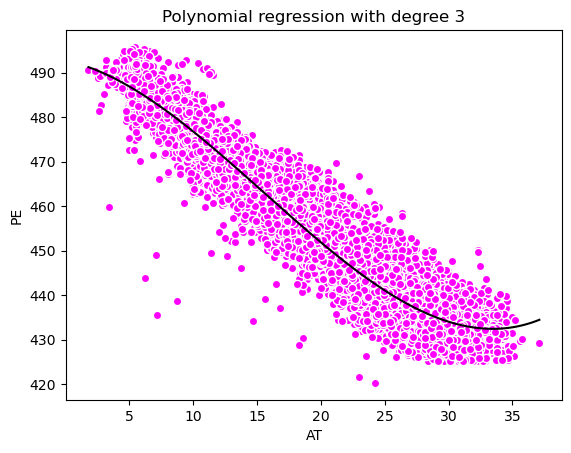

Summary of predictor AT :
                             OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.912
Model:                            OLS   Adj. R-squared:                  0.912
Method:                 Least Squares   F-statistic:                 3.299e+04
Date:                Sun, 13 Jun 2021   Prob (F-statistic):               0.00
Time:                        13:52:38   Log-Likelihood:                -29101.
No. Observations:                9568   AIC:                         5.821e+04
Df Residuals:                    9564   BIC:                         5.824e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    492.7281    

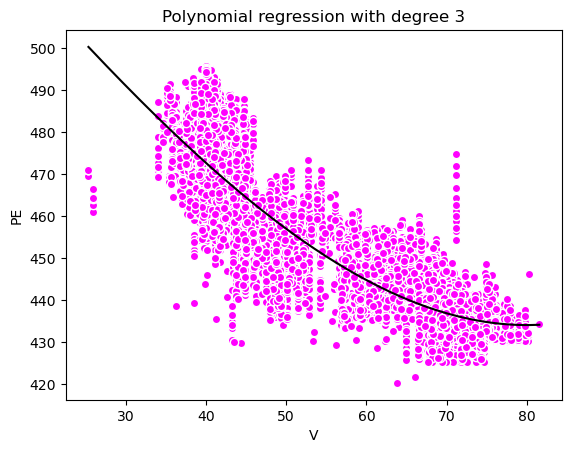

Summary of predictor V :
                             OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.775
Model:                            OLS   Adj. R-squared:                  0.775
Method:                 Least Squares   F-statistic:                 1.098e+04
Date:                Sun, 13 Jun 2021   Prob (F-statistic):               0.00
Time:                        13:52:39   Log-Likelihood:                -33585.
No. Observations:                9568   AIC:                         6.718e+04
Df Residuals:                    9564   BIC:                         6.721e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    554.1468     

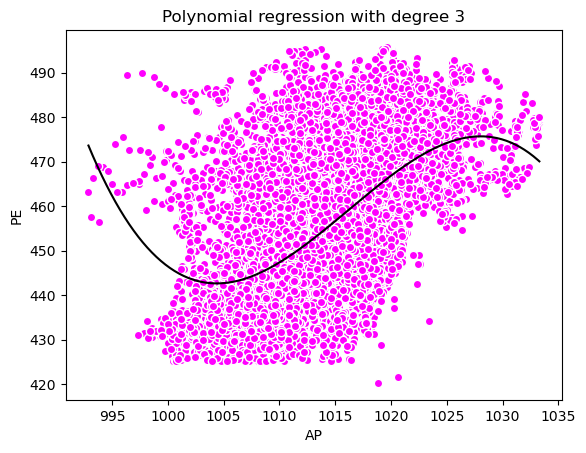

Summary of predictor AP :
                             OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.275
Model:                            OLS   Adj. R-squared:                  0.275
Method:                 Least Squares   F-statistic:                     1813.
Date:                Sun, 13 Jun 2021   Prob (F-statistic):               0.00
Time:                        13:52:39   Log-Likelihood:                -39184.
No. Observations:                9568   AIC:                         7.837e+04
Df Residuals:                    9565   BIC:                         7.840e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0747    

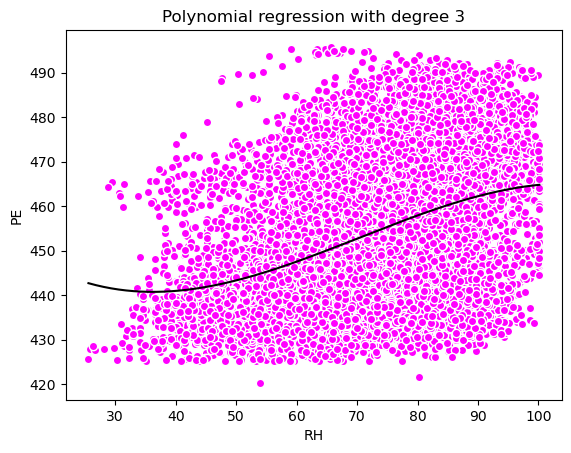

Summary of predictor RH :
                             OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.154
Model:                            OLS   Adj. R-squared:                  0.153
Method:                 Least Squares   F-statistic:                     579.2
Date:                Sun, 13 Jun 2021   Prob (F-statistic):               0.00
Time:                        13:52:39   Log-Likelihood:                -39923.
No. Observations:                9568   AIC:                         7.985e+04
Df Residuals:                    9564   BIC:                         7.988e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    468.4135    

In [17]:
degree=3
y = df['PE']
polyreg=make_pipeline(PolynomialFeatures(degree),LinearRegression())

for i in range(len(features)):
    X = np.asarray(df_features[i])
    X = X.reshape(-1,1)
    X_seq = np.linspace(X.min(),X.max(),300).reshape(-1,1)
    ftx = features[i]
    polyreg.fit(X,y)
    plt.figure()
    plt.scatter(X,y,color = 'magenta',edgecolor = 'white')
    plt.xlabel(features[i])
    plt.ylabel('PE')
    plt.plot(X_seq,polyreg.predict(X_seq),color="black")
    plt.title("Polynomial regression with degree "+str(degree))
    plt.show()
    model = ols(formula = "PE ~ "+ ftx +" + I("+ ftx + "**2) + I(" + ftx + "**3)",data=df).fit()
    print("Summary of predictor",features[i],":\n",model.summary())

By fitting non-linear models with all the predictors individually, we could see the p-value of each term is small i.e. less than significance level of 0.05 except for predictor V that has the p-value (0.768) of quadratic term larger than the significance level (0.05). This leads us to reject the null hypothesis for all predictors except for V, which turns out evidence to prove the non-linear association between predictors AT, AP, RH and response (PE). And not reject the null hypothesis for predictor V proving that non-linear association between V and PE is not present.

## Full Linear Regression model with all Pairwise interaction terms

In [18]:
model = ols(formula = 'PE ~ AT + V + AP + RH + I(AT*V) + I(AT*AP) + I(AT*RH) + I(V*AP) + I(V*RH) + I(AP*RH)', data=df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.936
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                 1.405e+04
Date:                Sun, 13 Jun 2021   Prob (F-statistic):               0.00
Time:                        13:52:39   Log-Likelihood:                -27548.
No. Observations:                9568   AIC:                         5.512e+04
Df Residuals:                    9557   BIC:                         5.520e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    685.7825     78.640      8.721      0.0

On fitting model with pairwise interactions terms, we could observe that the p-values of 'AT', 'AP' and 'RH' are close to the 0.05 significance level bound. Also, there exists interaction terms statistically significant at 0.05 significance level, such as AT & V, AT & RH, V & AP and AP & RH which proves that there is an association of interaction of predictors with the response. Based on the hierarchical principle, we still keep the main effects in the model.

In [19]:
train, test = train_test_split(df, train_size = 0.7, test_size=0.3, random_state=42)

In [20]:
print("Train size:",train.shape)
print("Test size:",test.shape)

Train size: (6697, 5)
Test size: (2871, 5)


## Improve your model using possible interaction terms or nonlinear associations between the predictors and response

**Fit Regression model with all predictors**

In [21]:
model = ols(formula = "PE ~"+ '+'.join(features), data = train).fit()
trainPredict = model.predict(train.iloc[:,:4])
testPredict = model.predict(test.iloc[:,:4])
trainMSE = np.square(np.subtract(train.PE,trainPredict)).mean()
testMSE = np.square(np.subtract(test.PE,testPredict)).mean()
MSEvals.loc['Linear Regression with all predictors'] = [trainMSE, testMSE]
trainMSE, testMSE

(20.58083972573866, 21.239856938225813)

**Fit Regression model with all predictors, interaction terms, and quadratic terms**

In [22]:
model = ols(formula = 'PE ~ AT + V + AP + RH + I(AT**2) + I(V**2) + I(AP**2) + I(RH**2) + I(AT*V) + I(AT*AP) + I(AT*RH) + I(V*AP) + I(V*RH) + I(AP*RH)', data = train).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.938
Model:                            OLS   Adj. R-squared:                  0.938
Method:                 Least Squares   F-statistic:                     7272.
Date:                Sun, 13 Jun 2021   Prob (F-statistic):               0.00
Time:                        13:52:39   Log-Likelihood:                -19160.
No. Observations:                6697   AIC:                         3.835e+04
Df Residuals:                    6682   BIC:                         3.845e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -7664.9809   1429.568     -5.362      0.0

We will be removing terms with its p-value higher than 0.05, which is 'V^2', 'AT & AP', 'V & AP' and 'V & RH'. We don't remove 'V' main effect based on hierachical priciple, even though its p-value is greater than 0.05, since there is interaction term ('AT' & 'V') included in the remaining model.
The hierarchical principle states that if we include an interaction in a model, we
should also include the main effects, even if the p-values associated with them are not significant. In other words, if the interaction between X1 and X2 seems important, then we should include both X1 and X2 in the model even if their coefficient estimates have large p-values.

In [23]:
model = ols(formula = 'PE ~ AT + V + AP + RH + I(AT**2) + I(AP**2) + I(RH**2) + I(AT*V) + I(AT*RH) + I(AP*RH)', 
                data = train).fit()

trainpredict = model.predict(train.iloc[:,:4])
testpredict = model.predict(test.iloc[:,:4])

trainMSE = np.square(np.subtract(train.PE,trainpredict)).mean()
testMSE = np.square(np.subtract(test.PE,testpredict)).mean()

MSEvals.loc['Linear Regression with interactions terms and non-linear associations'] = [trainMSE, testMSE]
trainMSE, testMSE

(17.91781267118548, 18.69434619080317)

**Report the Train and Test MSEs**

In [24]:
print(tabulate(MSEvals, MSEvals.columns, tablefmt="grid"))

+-----------------------------------------------------------------------+------------+-----------+
|                                                                       |   trainMSE |   testMSE |
+=======================================================================+============+===========+
| Linear Regression with all predictors                                 |    20.5808 |   21.2399 |
+-----------------------------------------------------------------------+------------+-----------+
| Linear Regression with interactions terms and non-linear associations |    17.9178 |   18.6943 |
+-----------------------------------------------------------------------+------------+-----------+


We can improve our model by including possible interaction terms and nonlinear associations between the predictors and response as evident by the decreasing MSE values from above table.

## KNN Regression

**k-nearest neighbor regression using raw features**

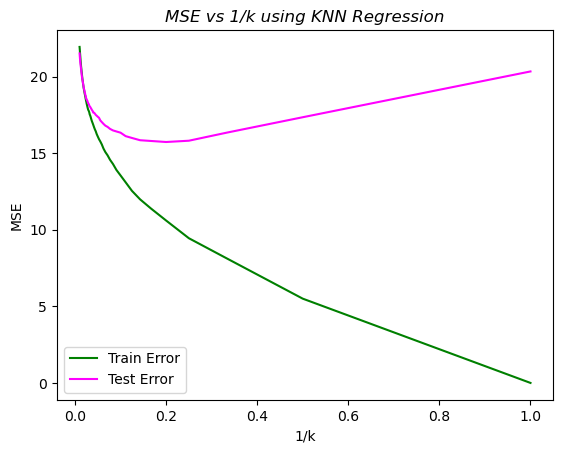

Best k: 5.0 and Least error: 15.73


In [25]:
trainerrorDict = {}
testerrorDict = {}

for k in range(1,101):
    knn = neighbors.KNeighborsRegressor(n_neighbors = k)
    knn.fit(train.iloc[:,:4], train.PE)  #fit the model
    trainpredict = knn.predict(train.iloc[:,:4])
    trainerrorDict[1/k] = np.square(np.subtract(train.PE,trainpredict)).mean()
    testpredict = knn.predict(test.iloc[:,:4])
    testerrorDict[1/k] = np.square(np.subtract(test.PE,testpredict)).mean()
plotTrainTestError(trainerrorDict, testerrorDict)

errorDict_sorted = sorted(testerrorDict.items(), key=operator.itemgetter(1))
# get value of K with min error (K*)
bestK = 1/errorDict_sorted[0][0]
leastTestError = errorDict_sorted[0][1]
print("Best k:",bestK,"and Least error:",round(leastTestError,2))

errorDict_sorted = sorted(trainerrorDict.items(), key=operator.itemgetter(1))
leastTrainError = errorDict_sorted[0][1]
MSEvals.loc['KNN Regression with raw features'] = [leastTrainError, leastTestError]

**k-nearest neighbor regression using normalized features**

In [26]:
# Normaliziation using MinMaxScaler
scaler = MinMaxScaler()
train_new = scaler.fit_transform(train)
test_new = scaler.fit_transform(test)

In [27]:
train_new = pd.DataFrame(train_new, columns = df.columns)
test_new = pd.DataFrame(test_new, columns = df.columns)

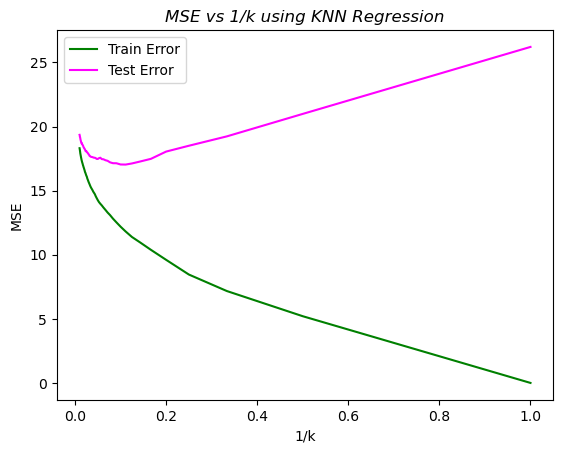

Best k: 9.0 and Least error: 17.03


In [28]:
trainerrorDict = {}
testerrorDict = {}

for k in range(1,101):
    knn = neighbors.KNeighborsRegressor(n_neighbors = k)
    knn.fit(train_new.iloc[:,:4], train.PE)  #fit the model
    trainpredict = knn.predict(train_new.iloc[:,:4])
    trainerrorDict[1/k] = np.square(np.subtract(train.PE,trainpredict)).mean()
    testpredict = knn.predict(test_new.iloc[:,:4])
    testerrorDict[1/k] = np.square(np.subtract(test.PE,testpredict)).mean()
plotTrainTestError(trainerrorDict, testerrorDict)

errorDict_sorted = sorted(testerrorDict.items(), key=operator.itemgetter(1))
# get value of K with min error (K*)
bestK = 1/errorDict_sorted[0][0]
leastTestError = errorDict_sorted[0][1]
print("Best k:",bestK,"and Least error:",round(leastTestError,2))

errorDict_sorted = sorted(trainerrorDict.items(), key=operator.itemgetter(1))
leastTrainError = errorDict_sorted[0][1]
MSEvals.loc['KNN Regression with normalized features'] = [leastTrainError, leastTestError]

## Compare the results of KNN Regression with the linear regression model that has the smallest test error 

In [29]:
print(tabulate(MSEvals, MSEvals.columns, tablefmt="grid"))

+-----------------------------------------------------------------------+------------+-----------+
|                                                                       |   trainMSE |   testMSE |
+=======================================================================+============+===========+
| Linear Regression with all predictors                                 |    20.5808 |   21.2399 |
+-----------------------------------------------------------------------+------------+-----------+
| Linear Regression with interactions terms and non-linear associations |    17.9178 |   18.6943 |
+-----------------------------------------------------------------------+------------+-----------+
| KNN Regression with raw features                                      |     0      |   15.7268 |
+-----------------------------------------------------------------------+------------+-----------+
| KNN Regression with normalized features                               |     0      |   17.0337 |
+---------

On comparing KNN Regression model with the Linear Regression model with lowest test error i.e. the LR model including the interaction terms and non-linear associations, we can observe that KNN Regression model performs better as the training MSE reduces to zero and test MSE is the lowest when using KNN regression with raw features and k = 5. The KNN algorithm uses ‘feature similarity’ to predict the values of any new data points. This means that the new point is assigned a value based on how closely it resembles the points in the training set. And as we saw the training set has zero MSE, it is evident that the KNN regression model was able to fit the data well, contributing to lowest test error eventually.<br>
Linear regression is an example of a parametric approach because it assumes a linear functional form for f(X). If we assume a linear relationship between X and Y but the true relationship is far from linear that is the case here, then the resulting model will provide a poor fit to the data, and any conclusions drawn from it will be suspect. As KNN is a non-parametric method, it does not assume an explicit form for f(X), providing a more flexible approach than Linear regression. Also, non-parametric methods work better when there are large number of observations per predictor as is the case here.

# ISLR: 2.4.1

For each of parts (a) through (d), indicate whether we would generally expect the performance of a flexible statistical learning method to be better or worse than an inflexible method. Justify your answer.

**(a)** The sample size n is extremely large, and the number of predictors p is small.<br>
**Ans:** *Better - Flexible statistical learning methods work better when we have an extremely large sample of size n (and low dimensionality), as it could capture more complex relationships without a high chance of overfitting.*

**(b)** The number of predictors p is extremely large, and the number of observations n is small.<br>
**Ans:** *Worse - Flexible statistical learning model will overfit with a small number of observations (and high dimension) and are at a higher risk of finding spurious relationships with the response. Hence, flexible methods are likely to underperform.*

**(c)** The relationship between the predictors and response is highly non-linear.<br>
**Ans:** *Better - Flexible statistical learning methods fit better for non-linear relationship and has less bias.*

**(d)** The variance of the error terms, i.e. $σ^2$ = Var($\epsilon$), is extremely high.<br>
**Ans:** *Worse - When we build a predictive model, we assume that there exists some relationship between the response Y and the predictors X=(X1,X2,...,Xp), which can be written in the form:*

Y = f(X) + $\epsilon$
*, where f is some fixed function of X, and $\epsilon$ is a random error term (independent of X), with mean zero i.e. the value we expect $\epsilon$ to take, on average, is zero:*
E[$\epsilon$] = 0

*We can show that the expected value of residual sum of squares, sqr(Y−Y^) can be expressed as:*

E[sqr(Y − Y^)] = E[sqr(f(X) + $\epsilon$ −f^(X))] = sqr(f(X) − f^(X)) + Var($\epsilon$)

*,where sqr[f(X)−f^(X)] is the reducible error, and Var($\epsilon$) is the irreducible error.*

*If irreducible error (Var($\epsilon$)) is very high, we would expect a flexible method to perform worse, as it can find relationships between the response and the large irreducible error that a less flexible method would not (it can overfit easily).*

# ISLR: 2.4.7

The table below provides a training data set containing six observations, three predictors, and one qualitative response variable. <br>

Suppose we wish to use this data set to make a prediction for Y when X1 = X2 = X3 = 0 using K-nearest neighbors.<br>
**(a)** Compute the Euclidean distance between each observation and the test point, X1 = X2 = X3 = 0.

**Ans:** *The Euclidean distance between points p and q is the length of the line segment connecting them pq.*

Formula: dist((x, y), (a, b)) = sqrt ((x - a)² + (y - b)²)

In [30]:
X = [[0,3,0],[2,0,0],[0,1,3],[0,1,2],[-1,0,1],[1,1,1]]
print('Computing Euclidean distance between each observation and test point (0, 0, 0), we get:')
for i in range( 0, len(X) ):
    dist = math.sqrt((0 - X[i][0])**2 + (0 - X[i][1])**2 + ( 0 - X[i][2])**2)
    print("Obsv", str(i+1),":",str(round(dist,4)))

Computing Euclidean distance between each observation and test point (0, 0, 0), we get:
Obsv 1 : 3.0
Obsv 2 : 2.0
Obsv 3 : 3.1623
Obsv 4 : 2.2361
Obsv 5 : 1.4142
Obsv 6 : 1.7321


**(b)** What is our prediction with K = 1? Why?<br>
**Ans:** *Green, since the single nearest neighbor to test point (0, 0, 0) is observation 5 (Point: (-1, 0, 1) and Euclidean distance = 1.4142).*<br>

**(c)** What is our prediction with K = 3? Why?<br>
**Ans:** *Red, since three nearest neighbors to test point (0, 0, 0) are observation 5, 6 and 2 with two of these having Y = “Red”, so the prediction would be “Red”.*

**(d)** If the Bayes decision boundary in this problem is highly nonlinear, then would we expect the best value for K to be large or small? Why?<br>
**Ans:** *The best value for K would be small because it is easy to fit in data with few K values and it would perform better for a nonlinear decision boundary. A small K would be more ‘flexible’ and the KNN boundary would be pulled in different directions easily, whereas a large K would have a ‘smoothing’ effect and produce a more linear boundary (hence, a worse classifier), because it will take more points into account.*

# References

https://blog.minitab.com/en/adventures-in-statistics-2/how-to-interpret-regression-analysis-results-p-values-and-coefficients<br>
https://datatofish.com/statsmodels-linear-regression/<br>
https://discuss.analyticsvidhya.com/t/getting-p-value-r-squared-and-adjusted-r-squared-value-in-python/31528/6<br>
https://www.theanalysisfactor.com/small-r-squared/<br>
https://www.theanalysisfactor.com/assessing-the-fit-of-regression-models/<br>
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html<br>
https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html